## IR Excess Identification From WISE

---

This notebook will take the sample of white dwarfs in SDSS-V, cross-match against Gaia and the AllWISE catalog, and search for infrared excess.

IRSA Explainer: https://wise2.ipac.caltech.edu/docs/release/allwise/expsup/sec2_1a.html

Stars within 100 pc of the Sun:  https://www.aanda.org/articles/aa/full_html/2021/05/aa39498-20/aa39498-20.html

LAMOST data cleaning procedure: https://iopscience.iop.org/article/10.3847/1538-4357/acaf5a/pdf
        

In [10]:
from astropy.io import fits
from astropy.table import Table, join, unique

from astropy.coordinates import SkyCoord
import astropy.units as u

from astropy.utils.metadata import merge
from astroquery.xmatch import XMatch

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


from multiprocessing import set_start_method

plt.style.use('stefan.mplstyle')

**01 - Catalog Matching**

---

`all_wds.dat` is the file generated from `00_sdss_v_wds.ipynb`, which contains all the SnowWhite-identified white dwarfs in SDSS. First, I cross-match that table against Gaia. Because SDSS objects are targeted from Gaia, this shouldn't reduce the sample size. My method for position cross-matching is to take a much greater area than I'd need then cut at the inflection point based on the idea that the number of sources in the background should increase as $$\frac{dN}{dr} = 2\pi r n.$$

WISE matching is a little trickier. Because WISE pixels are very big, I need a lot of information to make data quality cuts. The `astroquery.XMatch.query` function, which is a wrapper for the [CDS XMatch tool](http://cdsxmatch.u-strasbg.fr/xmatch) doesn't offer much flexibility about what columns to use. The slightly janky workaround is to split this up into two queries:
1. Use the CDS XMatch tool to figure out what the WISE XMatches are.
2. Drop all columns returned by CDS XMatch except the WISE designator, WISE RA, and WISE DEC.
3. Directly query the AllWISE TAP service at  https://irsa.ipac.caltech.edu/TAP/sync using a curl request, uploading a custom table
4. Match the returned table to the original table.

This returns every column that WISE collects. That's probably a bit too much data, but hey, no such thing as too much data.

In [11]:
catalog = Table.read('data/all_wds.dat', format='ipac')

table = XMatch.query(cat1=catalog,
                     cat2='vizier:I/355/gaiadr3',
                     max_distance=3 * u.arcsec, colRA1='ra',
                     colDec1='dec')

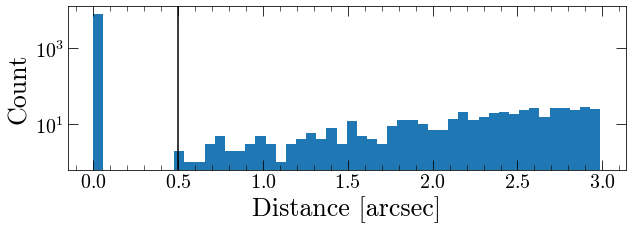

In [12]:
plt.figure(figsize = (10,3))
plt.hist(table['angDist'], bins = 50)
plt.axvline(x = 0.5, c = 'k')
plt.xlabel('Distance [arcsec]')
plt.ylabel('Count')
plt.yscale('log')

table = table[table['angDist'] < 0.4]
table.rename_column('angDist', 'angDist_gaia')

In [4]:
test_table = XMatch.query(cat1=table,
                     cat2='vizier:II/328/allwise',
                     max_distance=10 * u.arcsec, colRA1='ra',
                     colDec1='dec')

test_table.remove_columns(['RAJ2000', 'DEJ2000', 'e_RAJ2000', 'e_DEJ2000', 'RADEcorJ2000',
                            'eeMaj','eeMin','eePA','W1mag','W2mag','W3mag','W4mag',
                           'Jmag','Hmag','Kmag','e_W1mag','e_W2mag','e_W3mag','e_W4mag','e_Jmag','e_Hmag','e_Kmag',\
                           'ID','ccf','ex','var','qph','pmRA2','e_pmRA2','pmDE2','e_pmDE2','d2M'])

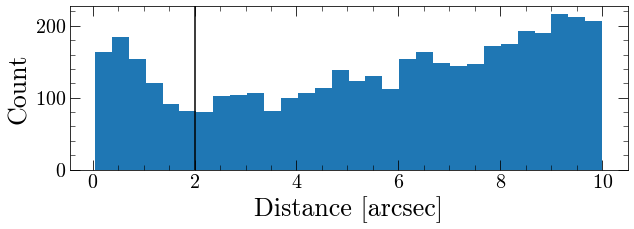

In [5]:
plt.figure(figsize = (10,3))
plt.hist(test_table['angDist'], bins = 30)
plt.axvline(x = 2, c = 'k')
plt.xlabel('Distance [arcsec]')
plt.ylabel('Count')

test_table = test_table[test_table['angDist'] < 2]
#table.rename_columns(['angDist', 'Source'], ['angDist_WISE', 'source_id'])

In [6]:
import os
from astropy.io import ascii
from astropy.table import join, unique

ascii.write(test_table[['AllWISE','RAJ20002', 'DEJ20002']], 'upload.tbl', overwrite=True, format='ipac')  

os.system('curl -o fp_psc.tbl -F "UPLOAD=my_table,param:table.tbl" -F "table.tbl=@upload.tbl" \
          -F "FORMAT=IPAC_TABLE" -F "QUERY=SELECT * FROM allwise_p3as_psd \
          WHERE CONTAINS(POINT(ra,dec), CIRCLE(TAP_UPLOAD.my_table.RAJ20002, TAP_UPLOAD.my_table.DEJ20002, 0.01)) =1" https://irsa.ipac.caltech.edu/TAP/sync ')

os.system('rm upload.tbl')
test = Table.read('fp_psc.tbl', format = 'ascii')
os.system('rm fp_psc.tbl')

test_table.remove_columns(['RAJ20002', 'DEJ20002'])

table = unique(join(test_table, test, keys_left = 'AllWISE', keys_right = 'designation', join_type = 'left'), keys = 'CATALOGID')

**02 - WISE Photometry Cleaning**

---

Currently, I'm making two cuts on the WISE photometry:
1. Photometry SNR: Anything with W1 or W2 SNR less than 10 is removed from the dataset. I'm not sure that this is the best cutoff to use, but we'll see.
2. Contamination: WISE has big pixels and WDs are faint, so it's easy for their signal to get contaminated by background stars. Fortunately, WISE has the `wXcc_map_str` column, which contains information about [diffraction spikes](https://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4g.html#diffraction_spikes), [short-term latent (persistent) images left by a bright source](https://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4g.html#latents), and [scattered light halos](https://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4g.html#halos).

Finally, I run a quick cone search of the Gaia archive on each target to see if there are any other stars within 6 arcsec (the WISE field of view) of the target. If there are, the photometry is probably contaminated. The Gaia depth of view is relatively shallow though, so this may not work 100% of the time. 

In [7]:
snr_thresh = 10

snr_mask = np.all([table['w1snr'] > snr_thresh, table['w2snr'] > snr_thresh], axis = 0)
contamination_mask = np.all([table['w1cc_map_str'] == None, table['w2cc_map_str'] == None], axis = 0)

mask = np.any([snr_mask, contamination_mask], axis = 0)

In [8]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
from IPython.utils import io

drops = []

for i in tqdm(range(len(catalog))):   
    coord = SkyCoord(ra=catalog['ra_1'][i], dec=catalog['dec_1'][i], unit=(u.degree, u.degree), frame='icrs')
    
    with io.capture_output() as captured:
        j = Gaia.cone_search_async(coord, radius=u.Quantity(6.0, u.arcsec), verbose = False).get_results();
    
    if len(j) != 1:
        drops.append(i)
        
catalog.remove_rows(drops)

  0%|          | 0/7971 [00:00<?, ?it/s]


KeyError: 'ra_1'

**03 - WD Photometry Correction**

---

Before I can do anything else, I need to get accurate distances and photometries. The distances will come from Bailer-Jones, and the photometries will be corrected for extinction using the Edenhofer+2023 dust maps.
1. Get accurate distances from the Bailer-Jones catalog.
2. Correct for white dwarf extinction using the Edenhofer+2023 dust map.
3. Use the Bailer-Jones distances to calculate better absolute magnitudes for all bands.
4. Plot color-magnitude diagrams and color-color diagrams against a sample of stars within 100pc of the solar system from [this paper.](https://www.aanda.org/articles/aa/full_html/2021/05/aa39498-20/aa39498-20.html)

In [ ]:
from astroquery.gaia import Gaia

ADQL_CODE1 = """SELECT dist.source_id, dist.r_med_geo
        FROM gaiadr3.gaia_source as gaia
        JOIN external.gaiaedr3_distance as dist
        ON gaia.source_id = dist.source_id      
        WHERE gaia.source_id in {}""".format(tuple(catalog['Source']))
gaia_d1 = Gaia.launch_job(ADQL_CODE1,dump_to_file=False).get_results()
        
catalog = join(catalog, gaia_d1, keys_left = 'Source', keys_right = 'source_id')

In [ ]:
from __future__ import print_function
from astropy.coordinates import SkyCoord
import astropy.units as u
from dustmaps.edenhofer2023 import Edenhofer2023Query

import pyphot
import extinction

#catalog['r_med_geo'] = 100 / catalog['PARALLAX']

# Coordinates using inverted parallax distances
coords = [SkyCoord(frame="icrs", ra=catalog['ra_1'][i]*u.deg, dec=catalog['dec_1'][i]*u.deg, distance = catalog['r_med_geo'][i] * u.pc) for i in range(len(catalog))]
catalog['wd_coords'] = coords


# Query Edenhofer2023 to get E(B-V) in arbitrary units
bsq = Edenhofer2023Query()
bsq_res = bsq.query(catalog['wd_coords']).copy()
bsq_res[np.isnan(bsq_res)] = 0

# Convert to actual units
Ebv = bsq_res*0.901*0.98
e_Ebv = Ebv*0.2

catalog['E(B-V)'] = Ebv
catalog['e_E(B-V)'] = e_Ebv


# Parameters for correcting using Gaia
Rv = 3.1
catalog['A_v0'] = catalog['E(B-V)']*Rv

# Fetch Gaia photometric band wavelengths and store in `gaia_phot_wavl`
lib = pyphot.get_library()
gaia_phot = [lib['Gaia_G'], lib['Gaia_BP'], lib['Gaia_RP']]
gaia_phot_wavl = np.array([x.lpivot.to('angstrom').value for x in gaia_phot])


# For each point, find extinction using the parameters we defined above
ext_all = []
for av0 in catalog['A_v0']:
    ext_all.append( extinction.fitzpatrick99(gaia_phot_wavl, av0, Rv) )
ext_all = np.array(ext_all)
    
# Save the extinction in each band
catalog['BP_ext'] = ext_all.T[0]
catalog['RP_ext'] = ext_all.T[1]

# Subtract out the extinction to find de-reddened magnitude
catalog['GAIA_G'] = catalog['Gmag'] - catalog['BP_ext']
catalog['GAIA_BP'] = catalog['BPmag'] - catalog['BP_ext']
catalog['GAIA_RP'] = catalog['RPmag'] - catalog['RP_ext']

In [ ]:
catalog['abs_g'] = catalog['GAIA_G'] - 5 * np.log10(catalog['r_med_geo']) + 5
catalog['abs_bp'] = catalog['GAIA_BP'] - 5 * np.log10(catalog['r_med_geo']) + 5
catalog['abs_rp'] = catalog['GAIA_RP'] - 5 * np.log10(catalog['r_med_geo']) + 5

catalog['bp_rp'] = catalog['abs_bp'] - catalog['abs_rp']

catalog['abs_w1'] = catalog['w1mpro'] - 5 * np.log10(catalog['r_med_geo'])# + 5
catalog['abs_w2'] = catalog['w2mpro'] - 5 * np.log10(catalog['r_med_geo'])# + 5
catalog['abs_w3'] = catalog['w3mpro'] - 5 * np.log10(catalog['r_med_geo'])# + 5
#catalog['abs_w4'] = catalog['w4mpro'] + 5 * np.log10(catalog['PARALLAX'] / 100)

catalog['distance'] = catalog['r_med_geo']

In [ ]:
allstars = Table.read('data/allstars.dat.gz', format='ipac')


plt.figure(figsize=(18,7))

plt.subplot(1,2,1)

plt.scatter(allstars['abs_bp'] - allstars['abs_rp'], allstars['abs_g'], c = 'k', alpha = 0.01)
plt.scatter(catalog['abs_bp'] - catalog['abs_rp'], catalog['abs_g'],  c = 'red', alpha = 0.6, marker = 'x', s = 10, label = 'SDSS-V White Dwarfs')

plt.xlabel(r'$G_{BP} - G_{RP}$')
plt.ylabel('G')
plt.gca().invert_yaxis()

plt.subplot(1,2,2)

plt.scatter(allstars['abs_bp'] - allstars['abs_rp'], allstars['abs_w1'] - allstars['abs_w2'], c = 'k', alpha = 0.01)
plt.scatter(catalog['abs_bp'] - catalog['abs_rp'], catalog['abs_w1'] - catalog['abs_w2'], c = 'red', alpha = 0.6, marker = 'x', s = 10, label = 'SDSS-V White Dwarfs')

plt.legend(framealpha = 0)

plt.ylim(-2,2)

plt.xlabel(r'$G_{BP} - G_{RP}$')
plt.ylabel('W1 - W2')

plt.savefig('plots/wise_cmd.pdf')

**04 - WD Template Spectra**

---

In order to identify IR excesses, I need to get accurate template spectra for what a lone WD would look like. I'm using [3D pure-hydrogen (DA) NLTE spectra from Tremblay et. al.](https://warwick.ac.uk/fac/sci/physics/research/astro/people/tremblay/modelgrids/). The cells in this section do, in order:

In [ ]:
import sys
sys.path.append('../corv/src')

import pyphot
from pyphot import unit
import corv
import lmfit

base_wavl, tremblay, table = corv.utils.build_montreal_da(path = '/home/sarsene1/corv/src/corv/models/montreal_da', flux_unit = 'flam')

lib = pyphot.get_library()
filters = [lib['Gaia_BP'], lib['Gaia_RP']]

c = 2.998e10
k = 1.38e-16
h = 6.626e-27
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
speed_light = 299792458 #m/s
mass_sun = 1.9884e30
newton_G = 6.674e-11
pc_to_m = 3.086775e16
radius_sun = 6.957e8

def mag_to_flux_spec(mag, filt, e_mag = None):
    if e_mag is not None:
        return (10**( (mag + filt.Vega_zero_mag) / -2.5 ), np.sqrt((-0.921034 * 10**(-0.4 * (mag + filt.Vega_zero_mag)) * e_mag)**2 ))
    else:
        return 10**( (mag + filt.Vega_zero_mag) / -2.5 )

def template(teff, logg, radius, distance):
    fl = tremblay((teff, logg))
    
    radius = radius * radius_sun # Rsun to meter
    distance = distance * pc_to_m # Parsec to meter
    
    fl = 4*np.pi*(radius / distance)**2 * fl
    return fl
    

def get_model_flux_gaia_spec(params):
    teff, logg, radius, distance = params['teff'], params['logg'], params['radius'], params['distance']
    
    fl = template(teff, logg, radius, distance) 
            
    flux = np.array([filters[i].get_flux(base_wavl * unit['angstrom'], fl * unit['erg/s/cm**2/angstrom'], axis = 1).to('erg/s/cm**2/angstrom').value for i in range(len(filters))])
    #mag = np.array([-2.5*np.log10(filters[i].get_flux(base_wavl * unit['AA'], fl * unit['erg/s/cm**2/AA'], axis = 1).value) - filters[i].Vega_zero_mag for i in range(len(filters))])
    return flux
    

def residual_gaia(params, obs_flux = None, e_obs_flux = None):
    model_flux = get_model_flux_gaia_spec(params)

    chisquare = ((model_flux - obs_flux) / e_obs_flux)**2
    
    #chisquare[np.isnan(chisquare)] = 1e8
    return chisquare



def get_parameters_gaia(obs_flux, e_obs_flux, id_ = None, floor_error = 0.02, make_plot = False, vary_logg = False, p0 = [10000, 8, 0.01, 100]):         
    params = lmfit.Parameters()

    params.add('teff', value = p0[0], min = 4001, max = 100000, vary = False)
    params.add('logg', value = p0[1], min=5, max=9, vary=False)
    params.add('radius', value = p0[2], min = 0.000001, max = 0.5, vary = True)
    params.add('distance', value = p0[3], min = 1, max = 2000, vary = False)
            
    result = lmfit.minimize(residual_gaia, params, kws = dict(obs_flux = obs_flux, e_obs_flux = e_obs_flux), method = 'leastsq')
            
    return result

In [ ]:
teff = []
logg = []
radius = []
drops = []

for i in tqdm(range(len(catalog))):
    obs_flux = [#mag_to_flux_spec(catalog['abs_g'][i], filters[0]),
                mag_to_flux_spec(catalog['GAIA_BP'][i], filters[0]), 
                mag_to_flux_spec(catalog['GAIA_RP'][i], filters[1])]
    e_obs_flux_gaia = np.array([obs_flux[0] * 1.09 * catalog['e_BPmag'][i],
                                obs_flux[1] * 1.09 * catalog['e_RPmag'][i]])
    
    try:
        temp = get_parameters_gaia(obs_flux, e_obs_flux_gaia, p0 = [catalog['Teff_SnowWhite'][i], catalog['Logg_SnowWhite'][i], 0.01, catalog['distance'][i]])

        teff.append(temp.params['teff'].value)
        logg.append(temp.params['logg'].value)
        radius.append(temp.params['radius'].value)
    except:
        drops.append(i)
    
catalog.remove_rows(drops)
catalog['fit_teff'] = teff
catalog['fit_logg'] = logg
catalog['fit_radius'] = radius

In [ ]:
lib = pyphot.get_library()
filt_full = [lib['Gaia_G'], lib['Gaia_BP'], lib['Gaia_RP'], lib['WISE_RSR_W1'], lib['WISE_RSR_W2']]

w1_dists = []
w2_dists = []

id_ = []

for i in tqdm(range(len(catalog))):
    fl = 4 * np.pi *tremblay((catalog['fit_teff'][i], catalog['fit_logg'][i])) * ( (catalog['fit_radius'][i] * radius_sun) / (catalog['distance'][i] * pc_to_m)) **2
    
    wavl = [filt_full[i].lpivot.to('angstrom').value for i in range(len(filt_full))]
    phot_flux = [filt_full[i].get_flux(base_wavl * unit['AA'], fl * unit['erg/s/cm**2/AA'], axis = 1).value for i in range(len(filt_full))]
    phot_mag = np.array([-2.5*np.log10(filt_full[i].get_flux(base_wavl * unit['AA'], fl * unit['erg/s/cm**2/AA'], axis = 1).value) \
                         - filt_full[i].Vega_zero_mag for i in range(len(filt_full))])
    
    obs_flux = np.array([mag_to_flux_spec(catalog['GAIA_G'][i], filt_full[0]),
                        mag_to_flux_spec(catalog['GAIA_BP'][i], filt_full[1]),
                        mag_to_flux_spec(catalog['GAIA_RP'][i], filt_full[2]),
                        mag_to_flux_spec(catalog['w1mpro'][i], filt_full[3]),
                        mag_to_flux_spec(catalog['w2mpro'][i], filt_full[4])])
    e_obs_flux = np.array([catalog['e_Gmag'][i] * 1.736011e-33 * 2.99792458e+21 / 6217.9**2,
                            catalog['e_BPmag'][i] * 2.620707e-33 * 2.99792458e+21 / 5109.7**2,
                             catalog['e_RPmag'][i] * 3.2988153e-33 * 2.99792458e+21 / 7769.1**2,
                            obs_flux[3] * 1.09 * catalog['w1sigm'][i],
                            obs_flux[4] * 1.09 * catalog['w2sigm'][i]])

    
    
    e_w1 = obs_flux[-2] * 1.09 * catalog['w1sigm'][i]
    e_w2 = obs_flux[-1] * 1.09 * catalog['w2sigm'][i]
    w1_dist = (obs_flux[-2] - phot_flux[-2]) / e_w1
    w2_dist = (obs_flux[-1] - phot_flux[-1]) / e_w2
    
    w1_dists.append(w1_dist)
    w2_dists.append(w2_dist)
    id_.append(i)
    
    plt.figure(figsize=(18,7))
    
    plt.subplot(1,2,1)
    
    mask1 = (3600 < base_wavl) * (base_wavl < 9000)
    
    plt.plot(base_wavl[mask1], fl[mask1], c = 'k')
    plt.errorbar([filt_full[j].lpivot.to('angstrom').value for j in range(len(filt_full))][:2], obs_flux[:2], yerr = e_obs_flux[:2], 
                 linestyle = 'none', marker = 'None', color = 'k', capsize = 5, label = 'Observed SED', zorder = 10)
    plt.scatter(wavl[:2], phot_flux[:2], c = 'blue', alpha = 0.7)
    #plt.errorbar(wavl[:2], phot_flux[:2], yerr = e_obs_flux[:2], linestyle = 'none', marker = 'None', color = 'k', capsize = 5, label = 'Observed SED', zorder = 10)

    
    plt.text(0.05, 0.20, "$T_{eff}$" + " = {:2.6} $K$".format(catalog['fit_teff'][i]), transform = plt.gca().transAxes, fontsize = 18)
    plt.text(0.05, 0.15, "$\log g$" + " = {:2.5f}".format(catalog['fit_logg'][i]), transform = plt.gca().transAxes, fontsize = 18)
    plt.text(0.05, 0.05, '$Distance = ${:2.1f} $pc$'.format(catalog['distance'][i]), transform = plt.gca().transAxes, fontsize=18)
    plt.text(0.05, 0.10, r'$Radius = ${:2.5f} $R_\odot$'.format(catalog['fit_radius'][i]), transform = plt.gca().transAxes, fontsize = 18)
    
    #plt.ylim(0.7*min(fl), 1.3*max(fl))
    
    plt.xlim((3600, 9000))
    plt.xlabel(r'Wavelength $[\AA]$')
    plt.ylabel('Flux $[erg/s/cm^2/\AA]$')
    
    plt.subplot(1,2,2)
    
    mask2 = (30000 < base_wavl) * (base_wavl < 50000)
    
    plt.plot(base_wavl, fl, c = 'k')
    plt.errorbar([filt_full[j].lpivot.to('angstrom').value for j in range(len(filt_full))], obs_flux, yerr = e_obs_flux, 
                 linestyle = 'none', marker = 'None', color = 'k', capsize = 5, label = 'Observed SED', zorder = 10)
    plt.scatter(wavl, phot_flux, c = 'blue', alpha = 0.7, label = 'Model SED')

    
    plt.text(0.05, 0.15, "$W1$ Distance" + " = {:2.2}".format(w1_dist), transform = plt.gca().transAxes, fontsize = 18)
    plt.text(0.05, 0.10, "$W2$ Distance" + " = {:2.2}".format(w2_dist), transform = plt.gca().transAxes, fontsize = 18)
    
    plt.yscale('log')
    plt.xlim(2500,50000)
    plt.xlabel(r'Wavelength $[\AA]$')
    plt.ylabel(r'Flux $[erg/s/cm^2/\AA]$')
    
    plt.legend(framealpha = 0)

    plt.savefig('plots/sed_fits/{}_sedfit.png'.format(i))
    
    plt.close()
    
catalog['id'] = id_
catalog['w1_dist'] = w1_dists
catalog['w2_dist'] = w2_dists

In [ ]:
plt.figure(figsize = (10,7))

plt.scatter(catalog['w1_dist'], catalog['w2_dist'], c = 'k')

plt.xlabel(r'W1 $\chi$')
plt.ylabel(r'W2 $\chi$')

#plt.xlim(-0.01e-14, 0.15e-14)
#plt.ylim(-0.01e-15, 0.5e-15)

plt.savefig('plots/WISE_discrepancy.pdf')

In [ ]:
mask = np.all([catalog['w1_dist'] > 3, catalog['w2_dist'] > 3], axis = 0)

print(catalog[mask][['ra_1', 'dec_1']])

In [ ]:
plt.figure(figsize=(18,7))

plt.subplot(1,2,1)

plt.scatter(allstars['abs_bp'] - allstars['abs_rp'], allstars['abs_g'], c = 'k', alpha = 0.01)
plt.scatter(catalog['abs_bp'] - catalog['abs_rp'], catalog['abs_g'],  c = 'red', alpha = 0.6, marker = 'x', s = 10, label = 'SDSS-V White Dwarfs')
plt.scatter(catalog[mask]['abs_bp'] - catalog[mask]['abs_rp'], catalog[mask]['abs_g'],  c = 'yellow', alpha = 0.6, marker = 'x', s = 10, label = 'Possible IR Excess')


plt.xlabel(r'$G_{BP} - G_{RP}$')
plt.ylabel('G')
plt.gca().invert_yaxis()

plt.subplot(1,2,2)

plt.scatter(allstars['abs_bp'] - allstars['abs_rp'], allstars['abs_w1'] - allstars['abs_w2'], c = 'k', alpha = 0.01)
plt.scatter(catalog['abs_bp'] - catalog['abs_rp'], catalog['abs_w1'] - catalog['abs_w2'], c = 'red', alpha = 0.6, marker = 'x', s = 10, label = 'SDSS-V White Dwarfs')
plt.scatter(catalog[mask]['abs_bp'] - catalog[mask]['abs_rp'], catalog[mask]['abs_w1'] - catalog[mask]['abs_w2'], c = 'yellow', alpha = 0.6, marker = 'x', s = 10, label = 'Possible IR Excess')


plt.legend(framealpha = 0)

plt.ylim(-2,2)

plt.xlabel(r'$G_{BP} - G_{RP}$')
plt.ylabel('W1 - W2')

plt.savefig('plots/wise_cmd_final.pdf')

In [ ]:
import numpy
from astropy.table import Table
import requests
from PIL import Image
from io import BytesIO

def getimages(ra,dec,filters="grizy"):
    
    """Query ps1filenames.py service to get a list of images
    
    ra, dec = position in degrees
    size = image size in pixels (0.25 arcsec/pixel)
    filters = string with filters to include
    Returns a table with the results
    """
    
    service = "https://ps1images.stsci.edu/cgi-bin/ps1filenames.py"
    url = f"{service}?ra={ra}&dec={dec}&filters={filters}"
    table = Table.read(url, format='ascii')
    return table


def geturl(ra, dec, size=240, output_size=None, filters="grizy", format="jpg", color=False):
    
    """Get URL for images in the table
    
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filters = string with filters to include
    format = data format (options are "jpg", "png" or "fits")
    color = if True, creates a color image (only for jpg or png format).
            Default is return a list of URLs for single-filter grayscale images.
    Returns a string with the URL
    """
    
    if color and format == "fits":
        raise ValueError("color images are available only for jpg or png formats")
    if format not in ("jpg","png","fits"):
        raise ValueError("format must be one of jpg, png, fits")
    table = getimages(ra,dec,filters=filters)
    url = (f"https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?"
           f"ra={ra}&dec={dec}&size={size}&format={format}")
    if output_size:
        url = url + "&output_size={}".format(output_size)
    # sort filters from red to blue
    flist = ["yzirg".find(x) for x in table['filter']]
    table = table[numpy.argsort(flist)]
    if color:
        if len(table) > 3:
            # pick 3 filters
            table = table[[0,len(table)//2,len(table)-1]]
        for i, param in enumerate(["red","green","blue"]):
            url = url + "&{}={}".format(param,table['filename'][i])
    else:
        urlbase = url + "&red="
        url = []
        for filename in table['filename']:
            url.append(urlbase+filename)
    return url


def getcolorim(ra, dec, size=240, output_size=None, filters="grizy", format="jpg"):
    
    """Get color image at a sky position
    
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filters = string with filters to include
    format = data format (options are "jpg", "png")
    Returns the image
    """
    
    if format not in ("jpg","png"):
        raise ValueError("format must be jpg or png")
    url = geturl(ra,dec,size=size,filters=filters,output_size=output_size,format=format,color=True)
    r = requests.get(url)
    im = Image.open(BytesIO(r.content))
    return im

In [ ]:
from astroquery.skyview import SkyView
import matplotlib.pyplot as plt
import matplotlib.patches as patch
from astropy.visualization import astropy_mpl_style

from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

from astroquery.sdss import SDSS

plt.style.use('../gravitational-redshift/stefan.mplstyle')

for i in tqdm(range(len(catalog[mask]))):
    coords = SkyCoord(catalog[mask]['ra_1'], catalog[mask]['dec_1'], unit = (u.deg, u.deg))
    
    paths_wise = SkyView.get_image_list(position=coords[i], survey=['WISE 3.4', 'WISE 4.6'], radius = 30*u.arcsec, grid = False)
    paths_compare = getcolorim(coords[i].ra.value, coords[i].dec.value, size=120, filters="grz")
    
    fig,ax = plt.subplots(ncols = 3, figsize = (30,9))
    
    
    ax[0].set_aspect('equal')
    
    # Show the image
    ax[0].imshow(fits.open(paths_wise[0])[0].data, cmap = 'gray')
    
    xmin, xmax = ax[0].get_xlim()
    ymin, ymax = ax[0].get_ylim()
    
    center = ((xmin + xmax) / 2, (ymin + ymax) / 2)
    radius = (5 / 30) * (np.abs(xmin) + np.abs(xmax))
    
    # Now, loop through coord arrays, and create a circle at each x,y pair
    circ = patch.Circle(center,radius, fill = False, color = 'blue')
    ax[0].add_patch(circ)
    
    ax[0].set_title('WISE 3.4 Image {}'.format(catalog[mask]['id'][i]))
    
    ax[0].set_aspect('equal')
    
    # Show the image
    try:
        ax[1].imshow(fits.open(paths_wise[1])[0].data, cmap = 'gray')
    
        xmin, xmax = ax[1].get_xlim()
        ymin, ymax = ax[1].get_ylim()
        
        center = ((xmin + xmax) / 2, (ymin + ymax) / 2)
        radius = (5 / 30) * (np.abs(xmin) + np.abs(xmax))
        
        # Now, loop through coord arrays, and create a circle at each x,y pair
        circ = patch.Circle(center,radius, fill = False, color = 'blue')
        ax[1].add_patch(circ)
    except:
        pass
    
    # Show the image
    try:
        ax[2].imshow(paths_compare)
    
        xmin, xmax = ax[2].get_xlim()
        ymin, ymax = ax[2].get_ylim()
        
        center = ((xmin + xmax) / 2, (ymin + ymax) / 2)
        radius = (5 / 30) * (np.abs(xmin) + np.abs(xmax))
        
        # Now, loop through coord arrays, and create a circle at each x,y pair
        circ = patch.Circle(center,radius, fill = False, color = 'blue')
        ax[2].add_patch(circ)
    except:
        pass
    
    ax[1].set_title('WISE 4.6 Image {}'.format(catalog[mask]['id'][i]))
    ax[2].set_title('PanSTARRS DR1 Image {}'.format(catalog[mask]['id'][i]))

    
    plt.savefig('plots/skyviews/{}_WISE.png'.format(catalog[mask]['id'][i]))
    plt.close()

In [ ]:
catalog.write('data/01_ir_excess.fits', overwrite = True)